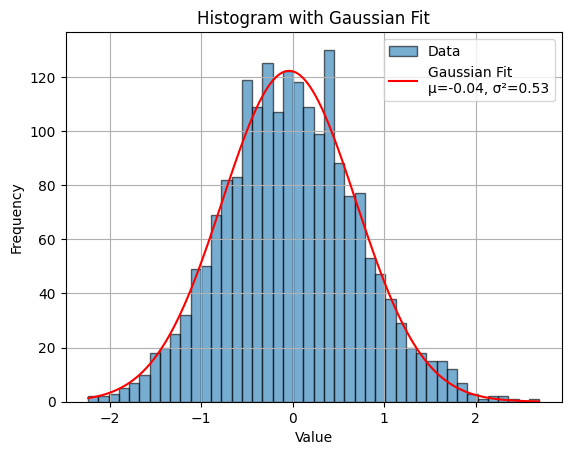

Среднее (μ): -0.0403
Дисперсия (σ²): 0.5325


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

# Гауссовская функция
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Функция для чтения первых чисел из файла
def read_first_numbers_from_file(filename):
    numbers = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                try:
                    number = float(parts[0])
                    numbers.append(number)
                except ValueError:
                    continue  # если не число — пропускаем
    return np.array(numbers)

# Основной код
filename = "20250505_140421.txt"  # <-- Замените на имя вашего файла
data = read_first_numbers_from_file(filename)

if data.size == 0:
    print("Нет данных для анализа.")
else:
    n_bins = int(np.sqrt(len(data)))
    counts, bin_edges = np.histogram(data, bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Начальные оценки параметров
    A_init = np.max(counts)
    mu_init = np.mean(data)
    sigma_init = np.std(data)

    try:
        popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[A_init, mu_init, sigma_init])
        A_fit, mu_fit, sigma_fit = popt

        # Рисуем гистограмму и фит
        plt.hist(data, bins=n_bins, alpha=0.6, label="Data", edgecolor='black')
        x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r-', label=f'Gaussian Fit\nμ={mu_fit:.2f}, σ²={sigma_fit**2:.2f}')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.title("Histogram with Gaussian Fit")
        plt.grid(True)
        plt.show()

        print(f"Среднее (μ): {mu_fit:.4f}")
        print(f"Дисперсия (σ²): {sigma_fit**2:.4f}")
    except RuntimeError:
        print("Не удалось аппроксимировать гистограмму гауссианой.")


In [8]:
import JFL5
Ds, Gs, es = JFL5.process_bed_files("D_small.bed", "G_small.bed")
print((len(es)))

Db, Gb, eb = JFL5.process_bed_files("D_big.bed", "G_big.bed")
print((len(eb)))

big = JFL5.map_genes_to_domains(Db, Gb, eb)


1239
61252


In [9]:
import numpy as np

def analyze_domains(D, G, e, label=""):
    print(f"\nАнализ выборки: {label}")
    
    # Маппинг
    mapped = JFL5.map_genes_to_domains(D, G, e)
    gene_counts = [len(dom) for dom in mapped]
    print(f"  Среднее число генов в домене до поворота: {np.mean(gene_counts):.2f}")

    total_vals_before = sum(len(dom) for dom in mapped)
    domain_lens_before = [len(dom) for dom in mapped]

    # Горизонтальные метрики до поворота
    mu1, d1 = JFL5.count_statvalues_horis_no_pad(mapped)
    print(f"  Среднее до поворота: {mu1:.4f}, дисперсия до поворота: {d1:.4f}")

    # Поворот
    rotated = JFL5.rotate_genes(mapped)

    # Тест: не изменилось ли количество доменов
    assert len(rotated) == len(mapped), f"Поворот изменил количество доменов: {len(rotated)} ≠ {len(mapped)}"

    # Тест: не изменились ли длины доменов
    domain_lens_after = [len(dom) for dom in rotated]
    assert domain_lens_after == domain_lens_before, f"Длины доменов изменились после поворота!"

    # Тест: не потерялись ли значения
    total_vals_after = sum(len(dom) for dom in rotated)
    assert total_vals_before == total_vals_after, f"Общее количество значений изменилось после поворота!"

    # Тест: структура данных
    assert all(isinstance(dom, list) or isinstance(dom, np.ndarray) for dom in rotated), \
        "Некоторые домены после поворота не являются списками или массивами"

    rotated_counts = [len(dom) for dom in rotated]
    print(f"  Среднее число генов в домене после поворота: {np.mean(rotated_counts):.2f}")

    # Горизонтальные метрики после поворота
    mu2, d2 = JFL5.count_statvalues_horis_no_pad(rotated)
    print(f"  Среднее после поворота: {mu2:.4f}, дисперсия после поворота: {d2:.4f}")

    z = JFL5.z_criterium(mu1, mu2, d1, d2, 1)
    print(f"Значение z - критерия: {z:.4f}")

    result = JFL5.Weilford_function(D, G, e, 100)
    print("Result: \n")
    print(result)

def replace_with_random_expressions(expressions):
    # Генерируем случайные числа для замену
    random_expressions = np.random.random(size=len(expressions))
    return random_expressions
    
analyze_domains(Db, Gb, replace_with_random_expressions(eb), label="Big")



Анализ выборки: Big
  Среднее число генов в домене до поворота: 2.98
  Среднее до поворота: 0.4058, дисперсия до поворота: 0.0478
  Среднее число генов в домене после поворота: 2.98
  Среднее после поворота: 0.3333, дисперсия после поворота: 0.0432
Значение z - критерия: 0.2400


2025-05-06 18:11:14,510 - Iteration 10/100 completed. Progress is good.
2025-05-06 18:11:30,618 - Iteration 20/100 completed. Progress is good.


KeyboardInterrupt: 

In [ ]:
from scipy.stats import f

def f_test(var_before, var_after, n_before, n_after):
    # Обязательно: большее значение в числителе
    if var_after > var_before:
        F = var_after / var_before
        dfn, dfd = n_after - 1, n_before - 1
    else:
        F = var_before / var_after
        dfn, dfd = n_before - 1, n_after - 1

    # Односторонний p-value (если просто хотим понять, есть ли различие)
    p_value = 1 - f.cdf(F, dfn, dfd)
    return F, p_value

# Пусть у нас есть два массива дисперсий: до и после поворота
var_before_1 = np.mean(var_neg)
var_after_1 = np.mean(var_neg_r)
n_1 = sum(len(d) for d in rot_neg)

var_before_2 = np.mean(var_pos)
var_after_2 = np.mean(var_pos_r)
n_2 = sum(len(d) for d in rot_pos)

# Применяем F-тест
F1, p1 = f_test(var_before_1, var_after_1, n_1, n_1)
F2, p2 = f_test(var_before_2, var_after_2, n_2, n_2)

print(f"Dataset 1: F = {F1:.2f}, p = {p1:.4g}")
print(f"Dataset 2: F = {F2:.2f}, p = {p2:.4g}")

# Кто из них Pattern?
if p1 < 0.01 and p2 > 0.1:
    print("Dataset 1 скорее всего Pattern.")
elif p2 < 0.01 and p1 > 0.1:
    print("Dataset 2 скорее всего Pattern.")
else:
    print("Невозможно уверенно классифицировать.")


from scipy.stats import norm

def p_to_z(p_value, direction='increase'):
    """
    Преобразует p-value в z-оценку.
    Если direction='increase', то большие z соответствуют меньшим p.
    """
    p_value = max(min(p_value, 1 - 1e-10), 1e-10)  # избегаем 0 и 1
    if direction == 'increase':
        return norm.ppf(1 - p_value)  # чем меньше p, тем больше z
    else:
        return norm.ppf(p_value)  # если z должен быть большим при большом p


F1, p1 = f_test(var_before_1, var_after_1, n_1, n_1)
F2, p2 = f_test(var_before_2, var_after_2, n_2, n_2)

z1 = p_to_z(p1)
z2 = p_to_z(p2)

print(f"Random-подобный z = {z1:.3f}")
print(f"Pattern-подобный z = {z2:.3f}")


In [2]:
import numpy as np

# Загрузка и маппинг
Ds, Gs, es = JFL5.process_bed_files("D_small.bed", "G_small.bed")
print(f"Размерность данных: {len(es)}")
small = JFL5.map_genes_to_domains(Ds, Gs, es)

# 1. small_neg — случайные экспрессии от 0 до 50
def generate_random_expressions(domains):
    return [[np.random.uniform(0, 50) for _ in domain] for domain in domains]

small_neg = generate_random_expressions(small)

# 2. small_pos — значения в домене +/- 5% от первого
def generate_positive_variation(domains):
    new_domains = []
    for domain in domains:
        if len(domain) > 1:
            first_value = domain[0]
            new_domain = [first_value * (1 + np.random.uniform(-0.05, 0.05)) for _ in domain]
        else:
            new_domain = domain
        new_domains.append(new_domain)
    return new_domains

small_pos = generate_positive_variation(small)

# Функция статистики
def calculate_mean_and_variance(domains):
    means = [np.mean(domain) for domain in domains]
    variances = [np.var(domain) for domain in domains]
    return np.mean(means), np.mean(variances)

# Статистика до поворота
mean_neg_avg, var_neg_avg = calculate_mean_and_variance(small_neg)
mean_pos_avg, var_pos_avg = calculate_mean_and_variance(small_pos)
print(f"[До поворота] Random: mean = {mean_neg_avg:.4f}, var = {var_neg_avg:.4f}")
print(f"[До поворота] Pattern: mean = {mean_pos_avg:.4f}, var = {var_pos_avg:.4f}")

# Поворот
rot_neg = JFL5.rotate_genes(small_neg)
rot_pos = JFL5.rotate_genes(small_pos)

# Статистика после одного поворота
mean_neg_avg_r, var_neg_avg_r = calculate_mean_and_variance(rot_neg)
mean_pos_avg_r, var_pos_avg_r = calculate_mean_and_variance(rot_pos)
print(f"[1 поворот] Random: mean = {mean_neg_avg_r:.4f}, var = {var_neg_avg_r:.4f}")
print(f"[1 поворот] Pattern: mean = {mean_pos_avg_r:.4f}, var = {var_pos_avg_r:.4f}")

# Функция для многократных поворотов
def rotate_multiple_times(domains, n=100):
    means, vars_ = [], []
    current = domains
    for _ in range(n):
        current = JFL5.rotate_genes(current)
        mean, var = calculate_mean_and_variance(current)
        means.append(mean)
        vars_.append(var)
    return np.mean(means), np.mean(vars_)

# Многократный поворот
mean_n, var_n = rotate_multiple_times(small_neg, n=1000)
mean_p, var_p = rotate_multiple_times(small_pos, n=1000)

print(f"[100 поворотов] Random: mean = {mean_n:.4f}, var = {var_n:.4f}")
print(f"[100 поворотов] Pattern: mean = {mean_p:.4f}, var = {var_p:.4f}")


NameError: name 'JFL5' is not defined

In [12]:
from Gene_rotor_matematics import process_bed_files, Weilford_function

# Загрузка данных
Ds, Gs, es = process_bed_files("D_small.bed", "G_small.bed")
Db, Gb, eb = process_bed_files("D_big.bed", "G_big.bed")

# Значения итераций
iteration_values = [10, 50, 100]

# Тестирование small dataset
print("===== Testing SMALL dataset =====")
for it in iteration_values:
    print(f"Iterations: {it}")
    result = Weilford_function(Ds, Gs, np.random.uniform(0, 50, len(eb)), it)
    print(f"Z: {result[0]:.3f}, mu1: {result[1]:.3f}, d1: {result[2]:.3f}, mu2: {result[3]:.3f}, d2: {result[4]:.3f}")
    print("---")

# Тестирование big dataset
print("\n===== Testing BIG dataset =====")
for it in iteration_values:
    print(f"Iterations: {it}")
    result = Weilford_function(Db, Gb, np.random.uniform(0, 50, len(eb)), it)
    print(f"Z: {result[0]:.3f}, mu1: {result[1]:.3f}, d1: {result[2]:.3f}, mu2: {result[3]:.3f}, d2: {result[4]:.3f}")
    print("---")


===== Testing SMALL dataset =====
Iterations: 10
Z: -0.108, mu1: 25.155, d1: 141.725, mu2: 24.952, d2: 144.921
---
Iterations: 50
Z: 0.033, mu1: 25.998, d1: 147.327, mu2: 25.386, d2: 142.574
---
Iterations: 100
Z: -0.107, mu1: 25.170, d1: 139.770, mu2: 25.094, d2: 142.825
---

===== Testing BIG dataset =====
Iterations: 10
Z: 1.901, mu1: 20.390, d1: 138.447, mu2: 7.972, d2: 64.665
---
Iterations: 50


KeyboardInterrupt: 

In [8]:
import Gene_rotor_matematics, JFL5
Ds, Gs, es = JFL5.process_bed_files("D_small.bed", "G_small.bed")
print(f"Размерность данных: {len(es)}")
small = JFL5.map_genes_to_domains(Ds, Gs, es)

def generate_random_expressions(domains):
    return [[np.random.uniform(0, 50) for _ in domain] for domain in domains]

def generate_positive_variation(domains):
    new_domains = []
    for domain in domains:
        if len(domain) > 1:
            first_value = domain[0]
            new_domain = [first_value * (1 + np.random.uniform(-0.05, 0.05)) for _ in domain]
        else:
            new_domain = domain
        new_domains.append(new_domain)
    return new_domains
    
small_neg = generate_random_expressions(small)
small_pos = generate_positive_variation(small)

small_neg_np = [np.array(sublist) for sublist in small_neg]
small_pos_np = [np.array(sublist) for sublist in small_pos]

small_neg = np.array(small_neg_np, dtype=object)
small_pos = np.array(small_pos_np, dtype=object)


Db, Gb, eb = Gene_rotor_matematics.process_bed_files("D_big.bed", "G_big.bed")
small_pos = Gene_rotor_matematics.map_genes_to_domains(Db, Gb, eb)

Размерность данных: 1239


In [9]:
from Gene_rotor_matematics import count_statvalues_horis_no_pad
mean_before, var_before = count_statvalues_horis_no_pad(small_neg)
print(f"BEFORE rotation NEG → mean: {mean_before:.3f}, var: {var_before:.3f}")
mean_before2, var_before2 = count_statvalues_horis_no_pad(small_pos)
print(f"BEFORE rotation POS → mean: {mean_before2:.3f}, var: {var_before2:.3f}")

# Создание массива из единиц той же структуры, что и small_neg_np
CALIBRATION_WEIGHTS = [np.ones_like(subarray) for subarray in small_neg_np]

# Подсчёт общего количества генов (сумма длин всех подмассивов)
GENE_COUNT = sum(len(subarray) for subarray in small_neg_np)

def rotate_genes(arr_of_domens):
    global CALIBRATION_WEIGHTS, GENE_COUNT

    flat_expr = np.concatenate(arr_of_domens)
    shift = int(np.random.uniform(-1, 1) * GENE_COUNT)
    rotated_expr = np.roll(flat_expr, shift)

    new_arr = np.empty(len(CALIBRATION_WEIGHTS), dtype=object)
    index = 0
    for i, weights in enumerate(CALIBRATION_WEIGHTS):
        n = len(weights)
        new_arr[i] = rotated_expr[index: index + n] * weights
        index += n
    return new_arr



# Один оборот
rotated_once = rotate_genes(small_neg)
mean_1, var_1 = count_statvalues_horis_no_pad(rotated_once)

rotated_once = rotate_genes(small_pos)
mean_1, var_1 = count_statvalues_horis_no_pad(rotated_once)

# Сто оборотов
meansn = []
vars_n = []
rotatedn = rotate_genes(small_neg)
meansp = []
vars_p = []
rotatedp = rotate_genes(small_pos)
for _ in range(10000):
    rotated = rotate_genes(rotatedn)
    mean, var = count_statvalues_horis_no_pad(rotated)
    meansn.append(mean)
    vars_n.append(var)
for _ in range(10000):
    rotated = rotate_genes(rotatedp)
    mean, var = count_statvalues_horis_no_pad(rotated)
    meansp.append(mean)
    vars_p.append(var)
mean_100 = np.mean(meansn)
var_100 = np.mean(vars_n)

mean_100p = np.mean(meansp)
var_100p = np.mean(vars_p)
print(f"AFTER 100 rotations NEG → mean: {mean_100:.3f}, var: {var_100:.3f}")
print(f"AFTER 100 rotations POS → mean: {mean_100p:.3f}, var: {var_100p:.3f}")



BEFORE rotation NEG → mean: 25.405, var: 104.200
BEFORE rotation POS → mean: 62.073, var: 1300.040
AFTER 100 rotations NEG → mean: 25.081, var: 106.348
AFTER 100 rotations POS → mean: 64.058, var: 997.411


In [10]:
print(Gene_rotor_matematics.z_criterium(mean_before, mean_100, var_before, var_100, 10000))
print(Gene_rotor_matematics.z_criterium(mean_before2, mean_100p, var_before2, var_100p, 10000)) 

-0.5710816222953723
0.160700815345922


In [46]:
import Gene_rotor_matematics as GRM
import JFL5
import numpy as np

# Получение мапнутых доменов из больших bed-файлов
Db, Gb, eb = GRM.process_bed_files("D_big.bed", "G_big.bed")
small_neg_raw = GRM.map_genes_to_domains(Db, Gb, eb)

# Генерация positive-версии на основе реальных доменов
def generate_positive_variation(domains):
    new_domains = []
    for domain in domains:
        if len(domain) > 1:
            first_value = domain[0]
            new_domain = [first_value * (1 + np.random.uniform(-0.05, 0.05)) for _ in domain]
        else:
            new_domain = domain
        new_domains.append(new_domain)
    return new_domains

# Конвертация в numpy-массивы (с учётом переменной длины)
small_neg_np = [np.array(sublist) for sublist in small_neg_raw]
small_pos_np = [np.array(sublist) for sublist in generate_positive_variation(small_neg_raw)]

# Обёртка в object-массив
small_neg = np.array(small_neg_np, dtype=object)
small_pos = np.array(small_pos_np, dtype=object)


In [47]:
from Gene_rotor_matematics import count_statvalues_horis_no_pad
mean_before, var_before = count_statvalues_horis_no_pad(small_neg)
print(f"BEFORE rotation NEG → mean: {mean_before:.3f}, var: {var_before:.3f}")
mean_before2, var_before2 = count_statvalues_horis_no_pad(small_pos)
print(f"BEFORE rotation POS → mean: {mean_before2:.3f}, var: {var_before2:.3f}")

# Создание массива из единиц той же структуры, что и small_neg_np
CALIBRATION_WEIGHTS = [np.ones_like(subarray) for subarray in small_neg_np]

# Подсчёт общего количества генов (сумма длин всех подмассивов)
GENE_COUNT = sum(len(subarray) for subarray in small_neg_np)

def rotate_genes(arr_of_domens):
    global CALIBRATION_WEIGHTS, GENE_COUNT

    flat_expr = np.concatenate(arr_of_domens)
    shift = int(np.random.uniform(-1, 1) * GENE_COUNT)
    rotated_expr = np.roll(flat_expr, shift)

    new_arr = np.empty(len(CALIBRATION_WEIGHTS), dtype=object)
    index = 0
    for i, weights in enumerate(CALIBRATION_WEIGHTS):
        n = len(weights)
        new_arr[i] = rotated_expr[index: index + n] * weights
        index += n
    return new_arr



# Один оборот
rotated_once = rotate_genes(small_neg)
mean_1, var_1 = count_statvalues_horis_no_pad(rotated_once)

rotated_once = rotate_genes(small_pos)
mean_1, var_1 = count_statvalues_horis_no_pad(rotated_once)

# Сто оборотов
meansn = []
vars_n = []
rotatedn = rotate_genes(small_neg)
meansp = []
vars_p = []
rotatedp = rotate_genes(small_pos)
for i in range(10):
    rotated = rotate_genes(rotatedn)
    mean, var = count_statvalues_horis_no_pad(rotated)
    meansn.append(mean)
    vars_n.append(var)

for i in range(10):
    rotated = rotate_genes(rotatedp)
    mean, var = count_statvalues_horis_no_pad(rotated)
    meansp.append(mean)
    vars_p.append(var)
    
mean_100 = np.mean(meansn)
var_100 = np.mean(vars_n)

mean_100p = np.mean(meansp)
var_100p = np.mean(vars_p)
print(f"AFTER 100 rotations NEG → mean: {mean_100:.3f}, var: {var_100:.3f}")
print(f"AFTER 100 rotations POS → mean: {mean_100p:.3f}, var: {var_100p:.3f}")



BEFORE rotation NEG → mean: 62.073, var: 1300.040
BEFORE rotation POS → mean: 55.449, var: 2.624
AFTER 100 rotations NEG → mean: 62.560, var: 1254.499
AFTER 100 rotations POS → mean: 53.780, var: 530.916


In [16]:
print(Gene_rotor_matematics.z_criterium(mean_before, mean_100, var_before, var_100, 100))
print(Gene_rotor_matematics.z_criterium(mean_before2, mean_100p, var_before2, var_100p, 100))

-0.009823561460873821
-13.688579115090073


In [4]:
from Gene_rotor_matematics import process_bed_files, map_genes_to_domains, Weilford_function
import numpy as np

# Исходные данные
Db, Gb, eb = process_bed_files("D_big.bed", "G_big.bed")
Domens = Db
Genes = Gb




# POSITIVE вариант (слегка варьирован)
def generate_positive_variation(domains):
    new_domains = []
    for domain in domains:
        if len(domain) > 1:
            first_value = domain[0]
            new_domain = [first_value * (1 + np.random.uniform(-0.05, 0.05)) for _ in domain]
        else:
            new_domain = domain
        new_domains.append(new_domain)
    return new_domains


mapped = map_genes_to_domains(Db, Gb, eb)
positive_domains = generate_positive_variation(mapped)
flattened_pos = [x for sub in positive_domains for x in sub]

# Дополнение нулями до длины eb
padded_pos = flattened_pos + [0.0] * (len(eb) - len(flattened_pos))
expressions_pos = np.array(padded_pos)

# Анализ с 100 ротациями
iterations = 100

print("=== NEGATIVE (реальные данные) ===")
z_neg, mu1_neg, d1_neg, mu2_neg, d2_neg, abra, kadabra = Weilford_function(Domens, Genes, eb, iterations)
print(f"Z: {z_neg:.3f}, mu1: {mu1_neg:.3f}, d1: {d1_neg:.3f}, mu2: {mu2_neg:.3f}, d2: {d2_neg:.3f}")

print("\n=== POSITIVE (контролируемое изменение) ===")
z_pos, mu1_pos, d1_pos, mu2_pos, d2_pos, abra, kadabra = Weilford_function(Domens, Genes, expressions_pos, iterations)
print(f"Z: {z_pos:.3f}, mu1: {mu1_pos:.3f}, d1: {d1_pos:.3f}, mu2: {mu2_pos:.3f}, d2: {d2_pos:.3f}")


=== NEGATIVE (реальные данные) ===
Z: 7.505, mu1: 62.073, d1: 1300.040, mu2: 2.806, d2: 66.970

=== POSITIVE (контролируемое изменение) ===
Z: 7.156, mu1: 43.668, d1: 636.797, mu2: 1.975, d2: 37.594


ахахахахахах что 

BEFORE rotation NEG → mean: 62.073, var: 1300.040
BEFORE rotation POS → mean: 55.437, var: 2.69

AFTER 100 rotations NEG → mean: 62.537, var: 1255.893
AFTER 100 rotations POS → mean: 53.716, var: 528.0550

In [49]:
import Gene_rotor_matematics as GRM
iterations = 10
Domens, Genes, expressions = GRM.process_bed_files("D_big.bed", "G_big.bed")


small_neg = GRM.map_genes_to_domains(Domens, Genes, expressions)
mean_before, var_before = GRM.count_statvalues_horis_no_pad(small_neg)

print(f'{mean_before: .2f}', f'{var_before:.2f}')

 62.07 1300.04


In [58]:
from Gene_rotor_matematics import *

def Weilford(Domens, Genes, expressions, iterations):
    mapper_method = get_mapper_method()
    if mapper_method not in {'middle', 'proportional', 'start', 'stop'}:
        raise ValueError(f'unknown type of mapping method in md file: {mapper_method}')

        
    orig = map_genes_to_domains(Domens, Genes, expressions)
    orig_domains = orig
    
    mean_before, var_before = count_statvalues_horis_no_pad(orig_domains)
    print(mean_before, var_before)
    global CALIBRATION_WEIGHTS
    length = len(CALIBRATION_WEIGHTS)
    
    means = np.empty(iterations)
    vars = np.empty(iterations)
    
    rotated = rotate_genes(orig_domains)
    
    for num in range(iterations):
        rotated = rotate_genes(orig_domains)
        mean_new, var_new = count_statvalues_horis_no_pad(rotated)
        
        means[num] = mean_new
        vars[num] = var_new
    fin_mean = np.sum(means)/iterations
    fin_var = np.sum(vars)/iterations
    z = z_criterium(mean_before, fin_mean, var_before, fin_var, iterations)
    return([z, mean_before, fin_mean, var_before, fin_var])

In [60]:
Weilford(Domens, Genes, expressions, 100)

62.07301690055779 1300.040018339932


[0.14394545224576424,
 62.07301690055779,
 50.831109394319775,
 1300.040018339932,
 1182.230202895378]

In [34]:
def generate_positive_variation(domains):
    new_domains = []
    for domain in domains:
        if len(domain) > 1:
            first_value = domain[0]
            new_domain = [first_value * (1 + np.random.uniform(-0.05, 0.05)) for _ in domain]
        else:
            new_domain = domain
        new_domains.append(new_domain)
    return new_domains